In [1]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
using .UnitTest
using .Geometry
using .Load
using .Misc
using Plots
using JSON

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


#### Hardcode gamma state vectors

In [2]:
m_state_vector_gamma, _, gamma_time = UnitTest.gamma_state_vectors();

#### Load in gamma LUT results from Matlab

In [3]:
json_path = "/Users/eyu/Google Drive/DTU/10_semester/Persistent_scaterer/phase bug investigation/forEigil20200407/diagonal.json"
gamma_lut_dictionary = Dict()
open(json_path, "r") do f
    global gamma_lut_dictionary
    dicttxt = read(f)  # file information to string
    #print(dicttxt)
    gamma_lut_dictionary = JSON.parse(String(dicttxt))  # parse and transform data
end;
indices_sample = gamma_lut_dictionary[1]["values"]
indices_line = gamma_lut_dictionary[2]["values"]
gamma_lats = gamma_lut_dictionary[3]["values"]
gamma_lons = gamma_lut_dictionary[4]["values"];

#### Load gamma DEM

In [5]:
# Should be function, but won't work inside module for some reason.
using JSON

path_to_gamma_json = "/Users/eyu/Google Drive/DTU/10_semester/Persistent_scaterer/phase bug investigation/forEigil20200407/srdem_subset.json"
srdem_subset = Dict()
open(path_to_gamma_json, "r") do f
    global srdem_subset
    dicttxt = read(f)  # file information to string
    srdem_subset = JSON.parse(String(dicttxt))  # parse and transform data
end
gamma_dem = Array{Float64}(undef, size(srdem_subset)..., size(srdem_subset[1])...)

for i in 1:length(srdem_subset)
    gamma_dem[i, :] = transpose(srdem_subset[i])
end

#### Load meta data

In [6]:
## LOADING
master_safe_path = "/Users/eyu/local_data/data/phase_bug/BB/S1B_IW_SLC__1SDV_20170408T053951_20170408T054019_005065_008DBC_AEEF.SAFE"
m_data_path, m_meta_path, m_calibration_path = Load.slc_paths(master_safe_path, "VV", 3);
m_meta = Load.slc_meta(m_meta_path);
m_pod = Load.precise_orbit(Load.pod_path(m_meta["t_0"], m_meta["mission_id"],
                        "/Users/eyu/local_data/data/phase_bug/POD"), m_meta["t_0"])
m_start_time, m_stop_time = UnitTest.meta_start_datetime(m_meta_path);

#### Create dictionary with relevant meta data with the correct fields

In [7]:
c = 299792458
gamma_meta = Dict()
gamma_meta["t_start"] = 20394.149330 - UnitTest.seconds_since_midnight(m_meta["t_0"])
gamma_meta["t_stop"] = 20402.797055 - UnitTest.seconds_since_midnight(m_meta["t_0"])
gamma_meta["right_looking"] = true
gamma_meta["incidence_angle_mid"] = 43.5926
gamma_meta["range_sampling_rate"] = 6.4345241e+07
gamma_meta["azimuth_frequency"] = 486.4863103
gamma_meta["slant_range_time"] = 902747.0461 * 2 / c;

#### Define master view, and compute latitude and longitude

In [8]:
# input
master_view = [1:size(gamma_dem)[1], 1:size(gamma_dem)[2]]

2-element Array{UnitRange{Int64},1}:
 1:4208
 1:1500

In [9]:
## FIRST PART OF LUT, INTERPOLATE HEIGHTS
line = collect(master_view[1])
sample = collect(master_view[2])

# Get master line and sample
master_line, master_sample = Misc.flatten(line, sample)

line_sample = hcat(master_line, master_sample)
heights = vec(gamma_dem)
state_vectors = m_state_vector_gamma # m_pod[1] # state_vector_gamma
time_state_vectors = gamma_time .- UnitTest.seconds_since_midnight(m_meta["t_0"]); # m_pod[2]

lat_lon = Geometry.to_lat_lon(line_sample, heights, state_vectors, time_state_vectors, gamma_meta; c = 299792458);

┌ Warning: `polyfit(x, y, n=length(x) - 1, sym=:x)` is deprecated, use `fit(Poly, x, y, n; var=sym)` instead.
│   caller = polyfit(::Array{Float64,1}, ::Array{Float64,1}, ::Int64) at deprecated.jl:56
└ @ Polynomials ./deprecated.jl:56


#### Compute differences

In [10]:
# reshape to grid
lat_grid = reshape(lat_lon[:, 1], (length(line), length(sample)))
lon_grid = reshape(lat_lon[:, 2], (length(line), length(sample)))

latitude_difference = Array{Float64}(undef, 100, 1)
longitude_difference = Array{Float64}(undef, 100, 1)

for i in range(1, stop=100)
    latitude_difference[i] = gamma_lats[i] - lat_grid[indices_line[i], indices_sample[i]]
    longitude_difference[i] = gamma_lons[i] - lon_grid[indices_line[i], indices_sample[i]]
end

In [11]:
println("Maximum difference in meters")
maximum(longitude_difference) * cosd(56) * 111120, maximum(latitude_difference) * 111120

Maximum difference in meters


(1.2613270963071878e-5, 0.00014432435364142293)

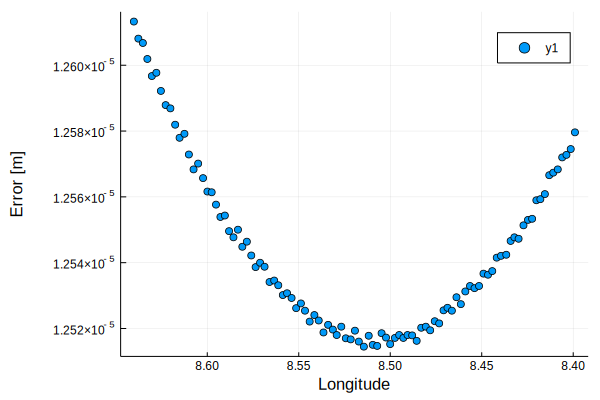

In [12]:
scatter(gamma_lons, longitude_difference .* cosd(56) .* 111120, xflip = true, xlabel = "Longitude", ylabel = "Error [m]")

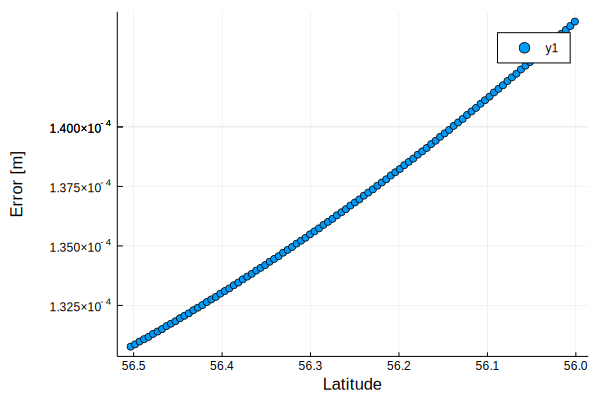

In [13]:
scatter(gamma_lats, latitude_difference .* 111200, xflip = true, xlabel = "Latitude", ylabel = "Error [m]")

#### Random indices

In [14]:
json_path = "/Users/eyu/Google Drive/DTU/10_semester/Persistent_scaterer/phase bug investigation/forEigil20200407/random.json"
gamma_lut_dictionary = Dict()
open(json_path, "r") do f
    global gamma_lut_dictionary
    dicttxt = read(f)  # file information to string
    #print(dicttxt)
    gamma_lut_dictionary = JSON.parse(String(dicttxt))  # parse and transform data
end;
indices_sample = gamma_lut_dictionary[1]["values"]
indices_line = gamma_lut_dictionary[2]["values"]
gamma_lats = gamma_lut_dictionary[3]["values"]
gamma_lons = gamma_lut_dictionary[4]["values"];

In [15]:
latitude_difference = Array{Float64}(undef, 100, 1)
longitude_difference = Array{Float64}(undef, 100, 1)

for i in range(1, stop=100)
    latitude_difference[i] = gamma_lats[i] - lat_grid[indices_line[i], indices_sample[i]]
    longitude_difference[i] = gamma_lons[i] - lon_grid[indices_line[i], indices_sample[i]]
end

In [16]:
println("Maximum difference in meters")
maximum(longitude_difference) * cosd(56) * 111120, maximum(latitude_difference) * 111120

Maximum difference in meters


(1.2641969347208103e-5, 0.00014444989290041121)

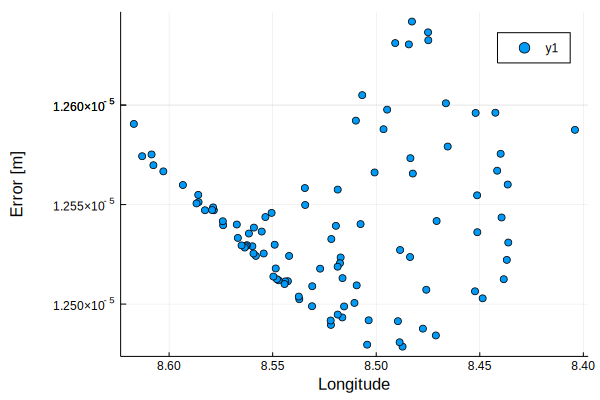

In [17]:
scatter(sort(gamma_lons), longitude_difference[sortperm(gamma_lons)] .* cosd(56) .* 111120, xflip = true, xlabel = "Longitude", ylabel = "Error [m]")

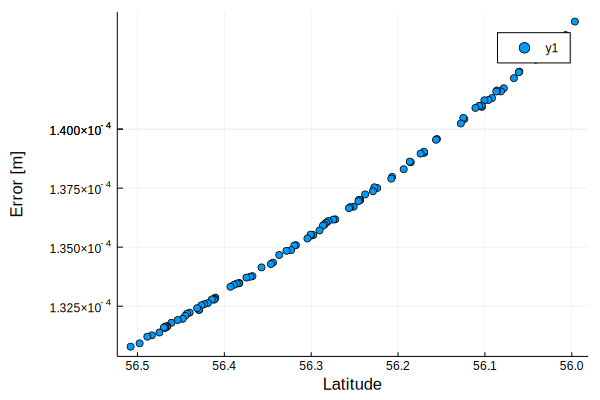

In [18]:
scatter(sort(gamma_lats), latitude_difference[sortperm(gamma_lats)] .* 111200, xflip = true, xlabel = "Latitude", ylabel = "Error [m]")

In [19]:
println("Approx error due to linear trend, for full swath:")
(56.68388333 - 54.98004722) * (maximum(latitude_difference) - minimum(latitude_difference)) / (maximum(gamma_lats) - minimum(gamma_lats)) * 111200

Approx error due to linear trend, for full swath:


4.586429554163544e-5